In [1]:
%reload_ext autoreload
%autoreload 2
import os
from torchsummary import summary
from torchvision import datasets,transforms
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler


c:\Users\Lasse\anaconda3\envs\DNN_project\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Lasse\anaconda3\envs\DNN_project\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Lasse\anaconda3\envs\DNN_project\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# from custom.mnist_net import FreeConvNetwork
from custom.mnist_net import FreeConvNetwork
# Testing & summarizeing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = FreeConvNetwork().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LocallyConnected2d-1           [-1, 32, 13, 13]          54,080
              ReLU-2           [-1, 32, 13, 13]               0
LocallyConnected2d-3             [-1, 64, 6, 6]         665,856
              ReLU-4             [-1, 64, 6, 6]               0
LocallyConnected2d-5            [-1, 128, 4, 4]       1,181,696
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                   [-1, 10]          20,490
              ReLU-9                   [-1, 10]               0
Total params: 1,922,122
Trainable params: 1,922,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 7.33
Estimated Total Size (MB): 7.50
---------------------------------------

In [18]:
# make a test and training set - CelebA
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5092611312866211, 0.4260057508945465, 0.3815517723560333], 
                          [0.27129703760147095, 0.24954678118228912, 0.24475571513175964])]
)

dataset = datasets.ImageFolder("./Data/img_align_celeba/class_data/", transform=transform)

#list all the labels in assigned to the dataset by the ImageFolder method
labels = [label for _, label in dataset]

#make a train/test split from based on the labels using StratifiedShuffleSplit to make sure all labels are evenly represented
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_indices, test_indices = next(splitter.split(dataset, labels))

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

#define the dataset loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))

Training set size: 4002
Testing set size: 1001


In [26]:
#caluclate the mean and standard deviation of the image dataset for image normalization 
means = 0
std = 0

for images, _ in train_loader:
    batch_samples  = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    means += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    break

means /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print("Means: ", means.tolist())
print("STD: ", std.tolist())
print(images.max())


Means:  [-0.00028080312767997384, -9.86437498795567e-06, 0.00010864814976230264]
STD:  [0.0009134745341725647, 0.0009159588953480124, 0.0010194007772952318]
tensor(2.5268)


In [8]:
#minst data set
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.MNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))



Training set size: 60000
Testing set size: 10000


In [22]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # moving the training data batch by batch to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # [a,b,c,d,f,e,g] = model(inputs) #debugging for NAN output
        
        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Adjust the Learning rate
        # scheduler.step()
        # print(optimizer.param_groups[0]["lr"])
        # Gather data and report
        running_loss += loss.item()
        
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [23]:
#moving model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FreeConvNetwork().to(device)
model = model.to(device)

#defining the loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)#), weight_decay=0.1) #weight decay = regularization to keep weights small
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01,total_iters=100)

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

# print(list(model.children()))
print(model)
EPOCHS = 2

best_vloss = 1_000_000.

if not os.path.isdir("./model"):
    os.makedirs("./model")

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    # model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
         
        # moving the test data batch by batch to the GPU
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        
        # validating the model
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.detach().item() # wihtout .detach I get an out of memory error on GPU


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 

TypeError: Exception encountered when calling layer 'locally_connected2d_19' (type LocallyConnected2D).

can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Call arguments received by layer 'locally_connected2d_19' (type LocallyConnected2D):
  • inputs=tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [22]:
#correct vs total classifications 
correct = 0
total = 0

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load the model
# model = FreeConvNetwork()
# model.load_state_dict(torch.load("./model/model_20230530_115318_4"))
# model.to(device)
#print(model.eval())

#predict the test labels
with torch.no_grad():
    for input, labels in test_loader:
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print("Validation Accuracy of the network: %f%%" % (100 * correct/total)) 

Validation Accuracy of the network: 33.066933%


In [21]:
num_c = 0
num_t = 0
with torch.no_grad():
    for i, (dfjk) in tqdm(enumerate(train_loader), total=len(test_loader)):
        x,y = dfjk[0], dfjk[1]
        x = x.to(device)
        y = y.to(device)
        
        scores = model(x)

        _,pred = scores.max(1)
        num_c += (pred == y).sum().item()
        num_t += pred.size(0)

acc = (num_c / num_t) * 100
print("Training Accuracy of the model: %f%%" %acc)


1001it [00:18, 54.38it/s]                        

Training Accuracy of the model: 99.825087%


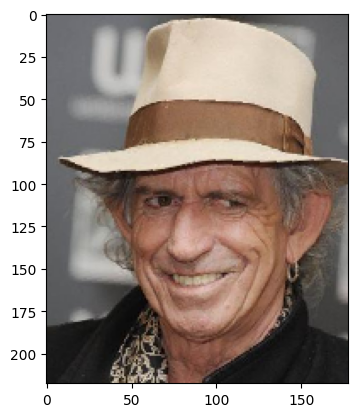

In [20]:
#visualize validation first validation sitmulus

input_image = next(iter(test_loader))[0]
plt.imshow(input_image[0,:,:,:].permute(1,2,0))
plt.show()



torch.Size([4, 1, 107, 87])


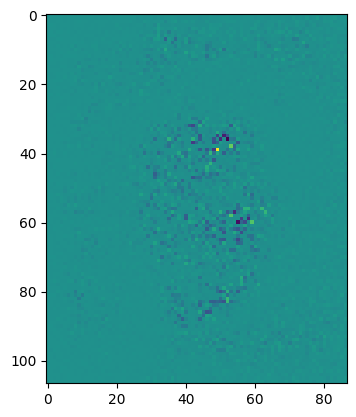

In [8]:
model_children = next(iter(model.children()))
fm= model_children[0](input_image.to(device))
print(fm.size())
fm = fm[0]
plt.imshow(fm[0,:,:].cpu().detach())
plt.show()

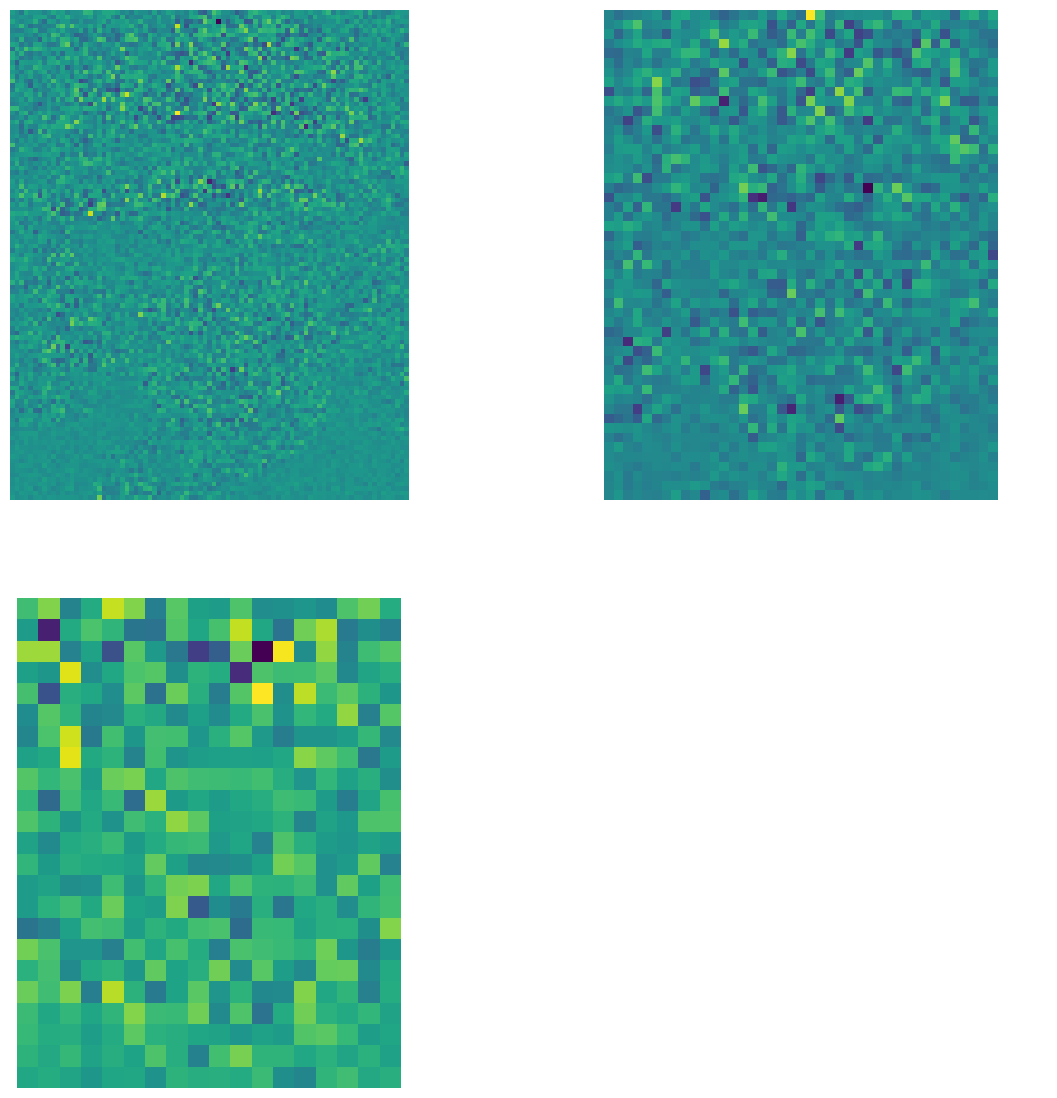

In [26]:
# visualize layers of conv network with only one output_channel
model_children = next(iter(model.children()))

list_feature_maps = []
list_feature_maps_relu = []
for layer in range(len(list(model_children))):
    if str(type(model_children[layer])) == "<class 'custom.LocallyConnected2d.LocallyConnected2d'>":
        if layer == 0:  
            l_input = input_image.to(device)
        else: 
            l_input = list_feature_maps_relu[-1]
        feature_map = model_children[layer](l_input)
        list_feature_maps.append(feature_map)
        feature_map_ReLU = model_children[layer+1](feature_map)
        list_feature_maps_relu.append(feature_map_ReLU)
        

numb_maps = len(list_feature_maps)
dim = math.ceil(math.sqrt(numb_maps))

fig, axs = plt.subplots(dim, dim, figsize=(14,14))
map_n = 0
for filt_x in range(dim):
    for filt_y in range(dim):
        try:
            feature_map = list_feature_maps[map_n]
            feature_map = feature_map[0,:,:,:]

            axs[filt_x, filt_y].imshow(feature_map[0,:,:].cpu().detach())
            axs[filt_x, filt_y].axis("off")
            map_n += 1
        except:
            IndexError
            axs[filt_x, filt_y].axis("off")
            pass
plt.show()


In [89]:
next(iter(model.children()))[1]

LocallyConnected2d()

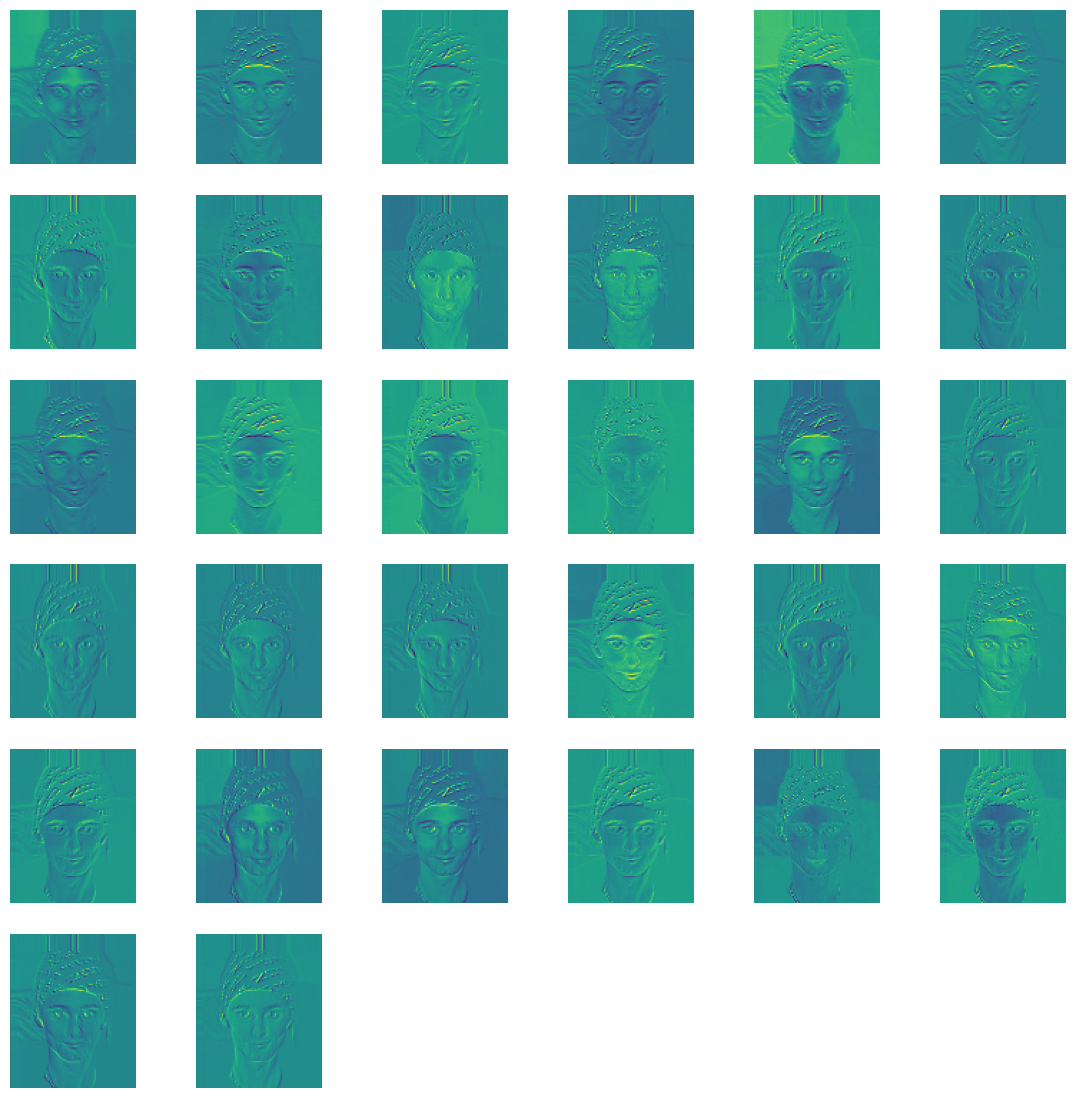

In [23]:
# visualize the first layer in a network with multiple out_channels
import math
import matplotlib.pyplot as plt

input_image = next(iter(test_loader))[0]
feature_map = next(iter(model.children()))[0](input_image.to(device))

feature_map = feature_map[0,:,:,:]
numb_filter = feature_map.size()[0]
dim = math.ceil(math.sqrt(numb_filter))

fig, axs = plt.subplots(dim, dim, figsize=(14,14))
filt_n = 0

for filt_x in range(dim):
    for filt_y in range(dim):
        
        try:
            axs[filt_x, filt_y].imshow(feature_map[filt_n,:,:].cpu().detach())
            axs[filt_x, filt_y].axis("off")
            filt_n += 1
        except:
            IndexError
            axs[filt_x, filt_y].axis("off")
            pass
plt.show()

In [45]:
import torchvision
import numpy as np
import torch.nn as nn
import custom
import matplotlib.pyplot as plt

#plot the weights 

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    _,n,c,w,h,_ = tensor.shape
    tensor = tensor[0,:,:,:,:,0]

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    fig = plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    return fig

def visualize_layers(model):
    figs = []
    _model = model.module if type(model) == nn.DataParallel else model
    for name, module in _model.named_modules():
        #print(module)
        if not isinstance(module, nn.Sequential):
            if type(module) == custom.LocallyConnected2d.LocallyConnected2d or type(module) == nn.Conv2d:
                filter = module.weight.cpu().data.clone()
                #filter = filter[0,0,:,:,:,:]
            else:
                continue
            
            fig = visTensor(filter, ch=0, allkernels=True)
            figs.append(fig)
            plt.axis('off')
            plt.title(f'Layer: {name}')
            plt.ioff()

    return figs

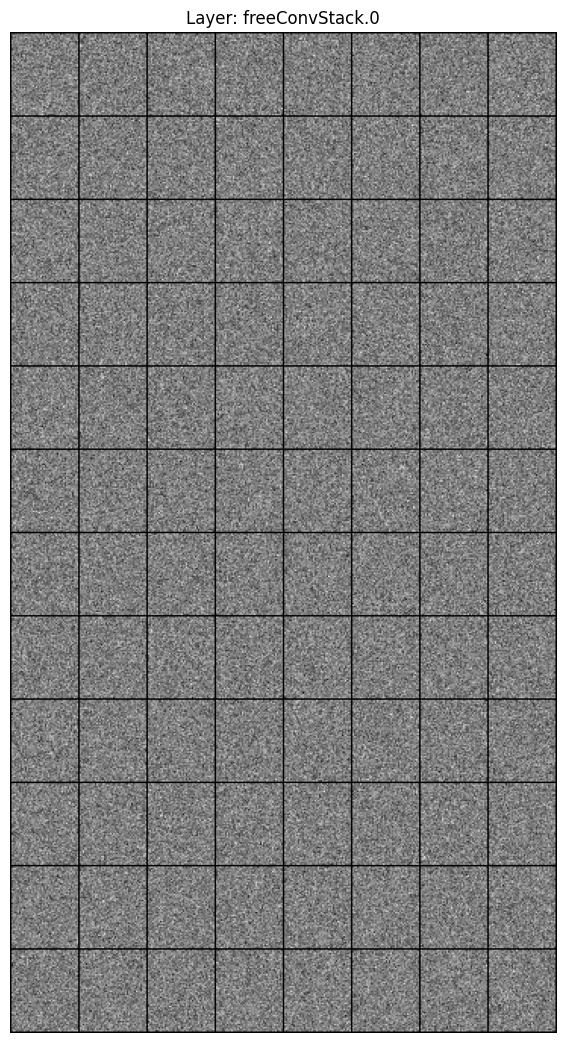

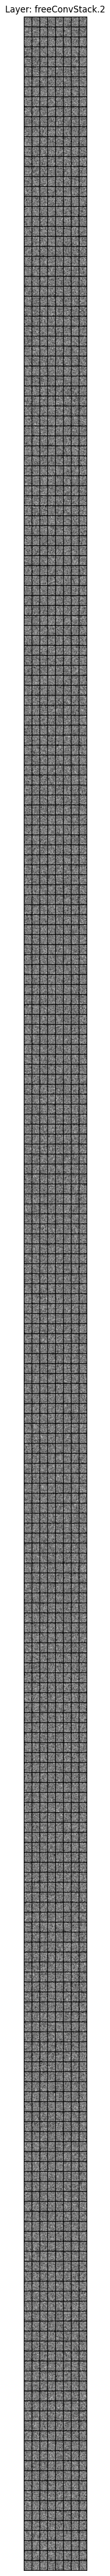

In [57]:

from custom.model import FreeConvNetwork
model = FreeConvNetwork()



fig = visualize_layers(model)

plt.show(fig)